In [31]:
%pip install sortedcontainers
%pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
#import das bibliotecas necessárias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from functools import cmp_to_key
from sortedcontainers import SortedList
from ucimlrepo import fetch_ucirepo 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [33]:
def orientation(p, q, r):
    """
    Determina a orientação do trio ordenado (p, q, r).
    Se o resultado for 0, então colinear
    Se for 1, então horário
    Se for -1, então anti-horário
    """
    val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)
    if val == 0:
        return 0
    return 1 if val > 0 else -1


def on_segment(p, q, r):
    """
    Verifica se o ponto q está no segmento pr
    """
    return (q.x <= max(p.x, r.x) and q.x >= min(p.x, r.x) and 
            q.y <= max(p.y, r.y) and q.y >= min(p.y, r.y))


In [34]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __sub__(self, other):
        return Ponto(self.x - other.x, self.y - other.y)

    def __repr__(self):
        return f"({self.x}, {self.y})"

    def distancia_ao_quadrado(self, other):
        return (self.x - other.x)**2 + (self.y - other.y)**2

class Segmento:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
    def __repr__(self):
        return f"[{self.p1}, {self.p2}]"
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __eq__(self, other):
        return isinstance(other, Segmento) and {self.p1, self.p2} == {other.p1, other.p2}
    
    def intersecao(self, other):
        o1 = orientation(self.p1, self.p2, other.p1)
        o2 = orientation(self.p1, self.p2, other.p2)
        o3 = orientation(other.p1, other.p2, self.p1)
        o4 = orientation(other.p1, other.p2, self.p2)

        # Condições principais de interseção
        if o1 * o2 < 0 and o3 * o4 < 0:
            return True

        # Casos especiais: se os segmentos são colineares e se cruzam
        if o1 == 0 and on_segment(self.p1, other.p1, self.p2):
            return True
        if o2 == 0 and on_segment(self.p1, other.p2, self.p2):
            return True
        if o3 == 0 and on_segment(other.p1, self.p1, other.p2):
            return True
        if o4 == 0 and on_segment(other.p1, self.p2, other.p2):
            return True

        return False

    
    def produto_vetorial(self, other):
        return (self.p2.x - self.p1.x) * (other.p2.y - other.p1.y) - (self.p2.y - self.p1.y) * (other.p2.x - other.p1.x)
    
    def __lt__(self, other):
        return self.p1.y < other.p1.y or (self.p1.y == other.p1.y and self.p2.y < other.p2.y)

class Event:
    def __init__(self, x, y, segment, is_start, poligono):
        self.x = x
        self.y = y
        self.segment = segment
        self.is_start = is_start
        self.poligono = poligono

    def __lt__(self, other):
        if self.x != other.x:
            return self.x < other.x
        return self.y < other.y

In [35]:
def ordenacao_polar(p0):
    def compare(p1, p2):
        o = orientation(p0, p1, p2)
        if o == 0:
            if p1.distancia_ao_quadrado(p0) < p2.distancia_ao_quadrado(p0):
                return -1
            else:
                return 1
        return 1 if o > 0 else -1
    return compare


In [36]:
#Algoritmo de Graham Scan para criar a envoltoŕia convexa

def graham_scan(pontos):
    if len(pontos) < 3:
        return pontos  # Retorna os pontos originais se houver menos de 3

    pontos = sorted(pontos, key=lambda p: (p.y, p.x))
    p0 = pontos[0]
    pontos_ordenados = sorted(pontos[1:], key=cmp_to_key(ordenacao_polar(p0)))

    envoltoria = [p0, pontos_ordenados[0]]
    for p in pontos_ordenados[1:]:
        while len(envoltoria) > 1 and Segmento(envoltoria[-2], envoltoria[-1]).produto_vetorial(Segmento(envoltoria[-1], p)) <= 0:
            envoltoria.pop()
        envoltoria.append(p)

    if len(envoltoria) > 2:
        envoltoria.append(p0)

    return envoltoria


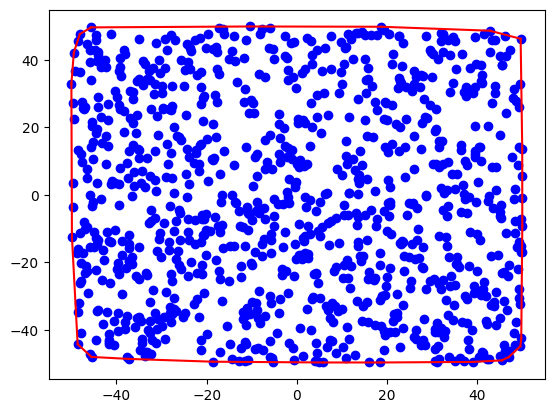

In [37]:
# Função para plotar a envoltória convexa

def plot_envoltoria(pontos, envoltoria):
    # Plotar todos os pontos
    plt.scatter([p.x for p in pontos], [p.y for p in pontos], color='b')

    # Plotar a envoltória convexa
    for i in range(len(envoltoria) - 1):
        plt.plot([envoltoria[i].x, envoltoria[i+1].x], [envoltoria[i].y, envoltoria[i+1].y], color='r')
    
    # Fechar a envoltória
    plt.plot([envoltoria[-1].x, envoltoria[0].x], [envoltoria[-1].y, envoltoria[0].y], color='r')
    
    plt.show()

# Gerar pontos aleatórios para testar o algoritmo e posteriormente plotar a envoltória convexa
pontos = [Ponto(random.uniform(-50, 50), random.uniform(-50, 50)) for _ in range(1000)]
envoltoria = graham_scan(pontos)
plot_envoltoria(pontos, envoltoria)

In [38]:
def cruzam(seg1, seg2):
    """ Verifica se os segmentos seg1 e seg2 se cruzam """
    # Usa sua função 'intersecao' já definida anteriormente
    return seg1.intersecao(seg2)


def segmentos_que_se_cruzam(segmentos, poligonos):
    segmento_para_poligono = {seg: pol for seg, pol in zip(segmentos, poligonos)}
    
    eventos = []
    for seg in segmentos:
        start = seg.p1 if seg.p1.x < seg.p2.x else seg.p2
        end = seg.p2 if seg.p1.x < seg.p2.x else seg.p1
        eventos.append((start, 'start', seg))
        eventos.append((end, 'end', seg))
    
    eventos.sort(key=lambda e: (e[0].x, e[0].y))

    # Usando SortedList da biblioteca sortedcontainers que é eficiente
    active_segments = SortedList(key=lambda s: (s.p1.y + s.p2.y) / 2)
    intersecoes = set()

    for ponto, tipo, segmento in eventos:
        if tipo == 'start':
            idx = active_segments.bisect(segmento)

            # Verificar interseção com segmento abaixo
            if idx > 0 and segmento.intersecao(active_segments[idx - 1]) and segmento_para_poligono[segmento] != segmento_para_poligono[active_segments[idx - 1]]:
                intersecoes.add(tuple(sorted([segmento, active_segments[idx - 1]])))

            # Verificar interseção com segmento acima
            if idx < len(active_segments) and segmento.intersecao(active_segments[idx]) and segmento_para_poligono[segmento] != segmento_para_poligono[active_segments[idx]]:
                intersecoes.add(tuple(sorted([segmento, active_segments[idx]])))

            active_segments.add(segmento)
        else:
            if segmento in active_segments:
                segmento_idx = active_segments.index(segmento)

                # Verificar interseção entre segmentos vizinhos
                if 0 < segmento_idx < len(active_segments) - 1:
                    seg_below = active_segments[segmento_idx - 1]
                    seg_above = active_segments[segmento_idx + 1]
                    if seg_below.intersecao(seg_above) and segmento_para_poligono[seg_below] != segmento_para_poligono[seg_above]:
                        intersecoes.add(tuple(sorted([seg_below, seg_above])))

                active_segments.remove(segmento)
    
    return list(intersecoes)


In [39]:
def verificar_separabilidade_linear(classe_1, classe_2):
    envoltoria_classe_1 = graham_scan(classe_1)
    envoltoria_classe_2 = graham_scan(classe_2)

    segmentos_classe_1 = [Segmento(envoltoria_classe_1[i], envoltoria_classe_1[i + 1]) for i in range(len(envoltoria_classe_1) - 1)]
    segmentos_classe_2 = [Segmento(envoltoria_classe_2[i], envoltoria_classe_2[i + 1]) for i in range(len(envoltoria_classe_2) - 1)]

    todos_os_segmentos = segmentos_classe_1 + segmentos_classe_2
    poligonos = [1] * len(segmentos_classe_1) + [2] * len(segmentos_classe_2)

    intersecoes = segmentos_que_se_cruzam(todos_os_segmentos, poligonos)
    return len(intersecoes) == 0


In [40]:
def plot_separabilidade(classe_1, classe_2):

    classe_1 = graham_scan(classe_1)
    classe_2 = graham_scan(classe_2)
    print(classe_1)
    print(classe_2)

    # Verificar se os dados são linearmente separáveis
    separaveis = verificar_separabilidade_linear(classe_1, classe_2)
    
    # Plotar envoltória da classe 1
    for i in range(len(classe_1) - 1):
        plt.plot([classe_1[i].x, classe_1[i + 1].x], 
                 [classe_1[i].y, classe_1[i + 1].y], 'b-')
    
    # Plotar envoltória da classe 2
    for i in range(len(classe_2) - 1):
        plt.plot([classe_2[i].x, classe_2[i + 1].x], 
                 [classe_2[i].y, classe_2[i + 1].y], 'r-')
    
    if separaveis:
        plt.title("Dados são linearmente separáveis!")
    else:
        plt.title("Dados não são linearmente separáveis!")
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

[(10, 2), (0, 2)]
[(5, 11), (11, 13), (9, 15), (5, 11)]


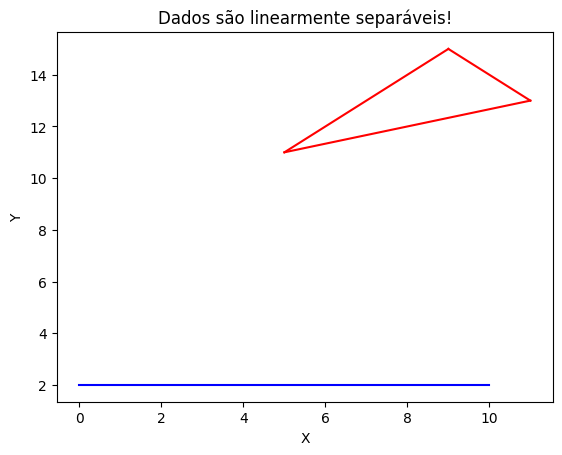

In [41]:
# Gerar pontos aleatórios para ambas as classes
classe_1_random = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(2)]
classe_2_random = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(3)]

plot_separabilidade(classe_1_random, classe_2_random)

In [42]:
def encontrar_pontos_mais_proximos(env1, env2):
    menor_distancia = float('inf')
    ponto1 = None
    ponto2 = None

    for p1 in env1:
        for p2 in env2:
            distancia = p1.distancia_ao_quadrado(p2)
            if distancia < menor_distancia:
                menor_distancia = distancia
                ponto1 = p1
                ponto2 = p2

    return ponto1, ponto2

def construir_modelo_linear(pontos1, pontos2):
    env1 = graham_scan(pontos1)
    env2 = graham_scan(pontos2)

    if not verificar_separabilidade_linear(env1, env2):
        print('Os dados não são linearmente separáveis.')
        return None

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)

    ponto_medio = Ponto((ponto1.x + ponto2.x) / 2, (ponto1.y + ponto2.y) / 2)
    vetor_direcao = Ponto(ponto2.x - ponto1.x, ponto2.y - ponto1.y)
    vetor_direcao_perpendicular = Ponto(vetor_direcao.y, -vetor_direcao.x)

    if vetor_direcao_perpendicular.x == 0:
        return 'vertical', ponto_medio.x, env1, env2
    else:
        m = vetor_direcao_perpendicular.y / vetor_direcao_perpendicular.x
        b = ponto_medio.y - m * ponto_medio.x
        return m, b, env1, env2

def plot_modelo(pontos1, pontos2):
    resultado = construir_modelo_linear(pontos1, pontos2)

    if resultado is None:
        return None
    
    modelo, b, env1, env2 = resultado

    ponto1, ponto2 = encontrar_pontos_mais_proximos(env1, env2)
    plt.fill([p.x for p in env1], [p.y for p in env1], color='blue', alpha=0.3)
    plt.fill([p.x for p in env2], [p.y for p in env2], color='red', alpha=0.3)
    plt.plot([p.x for p in env1 + [env1[0]]], [p.y for p in env1 + [env1[0]]], 'b-')
    plt.plot([p.x for p in env2 + [env2[0]]], [p.y for p in env2 + [env2[0]]], 'r-')
    plt.plot([ponto1.x, ponto2.x], [ponto1.y, ponto2.y], 'g--')
    
    if modelo == 'vertical':
        plt.axvline(x=b, color='c', label='Modelo Linear')
    else:
        m = modelo
        x_vals = [min([p.x for p in env1 + env2]), max([p.x for p in env1 + env2])]
        y_vals = [m*x+b for x in x_vals]
        plt.plot(x_vals, y_vals, 'c-', label='Modelo Linear')

    # Ajuste a escala dos eixos x e y conforme necessário
    # Defina os limites x e y para ajustar a escala do gráfico
    plt.xlim(min([p.x for p in env1 + env2]) - 1, max([p.x for p in env1 + env2]) + 1)
    plt.ylim(min([p.y for p in env1 + env2]) - 1, max([p.y for p in env1 + env2]) + 1)

    plt.legend()
    plt.show()


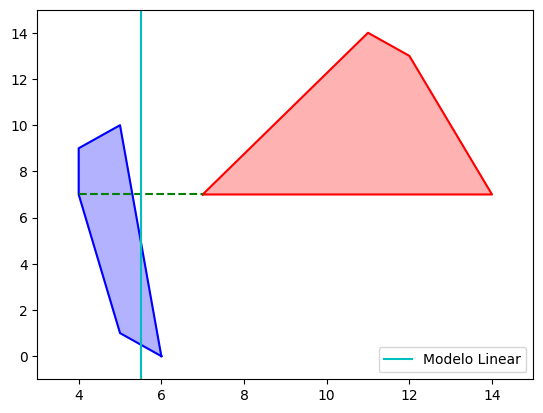

In [43]:
# Gerar pontos aleatórios para testar
classe_1 = [Ponto(random.randint(0, 10), random.randint(0, 10)) for _ in range(5)]
classe_2 = [Ponto(random.randint(5, 15), random.randint(5, 15)) for _ in range(5)]

plot_modelo(classe_1, classe_2)

In [44]:
def classificar_pontos_teste(ponto, modelo):
    if modelo[0] == 'vertical':
        return 1 if ponto.x > modelo[1] else 2
    else:
        y_modelo = modelo[0] * ponto.x + modelo[1]
        return 1 if ponto.y >= y_modelo else 2

def calcular_metricas_teste(pontos1, pontos2, modelo):
    VP = sum(1 for ponto in pontos1 if classificar_pontos_teste(ponto, modelo) == 1)
    FN = len(pontos1) - VP

    VN = sum(1 for ponto in pontos2 if classificar_pontos_teste(ponto, modelo) == 2)
    FP = len(pontos2) - VN

    precisao = VP / (VP + FP) if (VP + FP) != 0 else 0
    revocacao = VP / (VP + FN) if (VP + FN) != 0 else 0
    f1_score = 2 * (precisao * revocacao) / (precisao + revocacao) if (precisao + revocacao) != 0 else 0

    return precisao, revocacao, f1_score

def plotar_classificacao(pontos1, pontos2):
    # Extrair coordenadas x e y dos pontos para plotagem
    modelo = construir_modelo_linear(pontos1, pontos2)
    if modelo is None:
        return [],[]
    
    x1, y1 = zip(*[(p.x, p.y) for p in pontos1])
    x2, y2 = zip(*[(p.x, p.y) for p in pontos2])
    
    # Plotar os pontos
    plt.scatter(x1, y1, color='blue', label='Classe 1')
    plt.scatter(x2, y2, color='red', label='Classe 2')
    
    # Plotar a reta do modelo
    if modelo[0] == 'vertical':
        plt.axvline(x=modelo[1], color='green', linestyle='--', label='Reta do Modelo')
    else:
        # Criando uma sequência de valores x para a reta
        x_reta = list(range(int(min(x1 + x2)) - 1, int(max(x1 + x2)) + 2))
        y_reta = [modelo[0] * x + modelo[1] for x in x_reta]
        
        plt.plot(x_reta, y_reta, color='green', linestyle='--', label='Reta do Modelo')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Classificação de Pontos com Modelo Linear')
    plt.grid(True)
    plt.show()
    

In [45]:
def gerar_pontos_aleatorios(qtd_pontos, limite_inf, limite_sup):
    """
    Gera uma lista de pontos aleatórios.
    
    :param qtd_pontos: Número de pontos a serem gerados.
    :param limite_inf: Tuple contendo os limites inferiores (x, y).
    :param limite_sup: Tuple contendo os limites superiores (x, y).
    :return: Lista de pontos aleatórios.
    """
    pontos = []
    for _ in range(qtd_pontos):
        x = random.uniform(limite_inf[0], limite_sup[0])
        y = random.uniform(limite_inf[1], limite_sup[1])
        pontos.append(Ponto(x, y))
    return pontos


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def apply_tsne(data, labels=list):
    # Normalizar os dados
    scaler = StandardScaler()
    data_normalized = scaler.fit_transform(data)


    """
    Aplica a redução de dimensionalidade t-SNE em um conjunto de dados.

    Parâmetros:
    - data (pandas DataFrame): Dados a serem reduzidos.
    - labels (pandas Series, opcional): Etiquetas para colorir os pontos.

    Retorna:
    - data_tsne (pandas DataFrame): DataFrame com as duas componentes do t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data_normalized)
    
    if labels is not None:
        unique_labels = sorted(labels.unique())
        colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

        for color, label in zip(colors, unique_labels):
            mask = labels == label
            plt.scatter(data_tsne[mask, 0], data_tsne[mask, 1], color=color, alpha=0.7, label=str(label))

    data_tsne_df = pd.DataFrame(data=data_tsne, columns=['Componente 1', 'Componente 2'])
    
    return data_tsne_df


In [47]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
iris = fetch_ucirepo(id=53) 
  
# data (as pandas dataframes) 
x = iris.data.features 
y = iris.data.targets 

irisData = pd.concat([x, y], axis=1)
irisData.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [48]:

irisTest = irisData.sample(frac = 0.3)
irisTrain = irisData.drop(irisTest.index)

versicolor = irisTrain[irisTrain['class'] == 'Iris-versicolor']

versicolor = versicolor.drop(labels=['sepal width', 'petal width'], axis=1)
versicolor.head(5)

setosa= irisTrain[irisTrain['class'] == 'Iris-setosa']
setosa = setosa.drop(labels=['sepal width', 'petal width'], axis=1)
setosa.head(5)
    


,sepal length,petal length,class
0,5.1,1.4,Iris-setosa
1,4.9,1.4,Iris-setosa
2,4.7,1.3,Iris-setosa
3,4.6,1.5,Iris-setosa
4,5.0,1.4,Iris-setosa


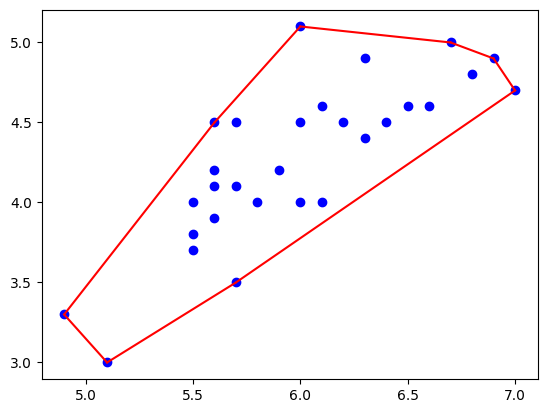

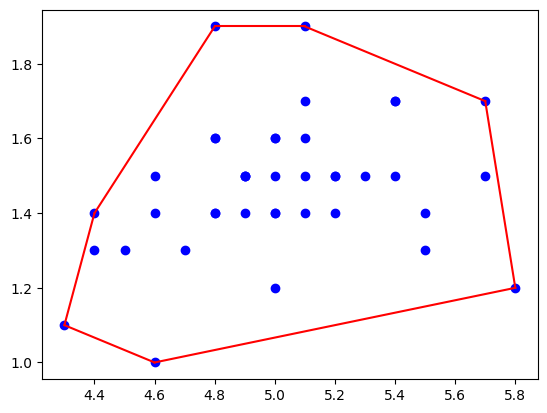

In [49]:
pointsVersicolor = [Ponto(row['sepal length'], row['petal length']) for index, row in versicolor.iterrows()]

versicolorEnv = graham_scan(pointsVersicolor)
plot_envoltoria(pointsVersicolor, versicolorEnv)

pointsSetosa = [Ponto(row['sepal length'], row['petal length']) for index, row in setosa.iterrows()]
setosaEnv = graham_scan(pointsSetosa)
plot_envoltoria(pointsSetosa, setosaEnv)

[(5.1, 3.0), (5.7, 3.5), (7.0, 4.7), (6.9, 4.9), (6.7, 5.0), (6.0, 5.1), (5.6, 4.5), (4.9, 3.3), (5.1, 3.0)]
[(4.6, 1.0), (5.8, 1.2), (5.7, 1.7), (5.1, 1.9), (4.8, 1.9), (4.4, 1.4), (4.3, 1.1), (4.6, 1.0)]


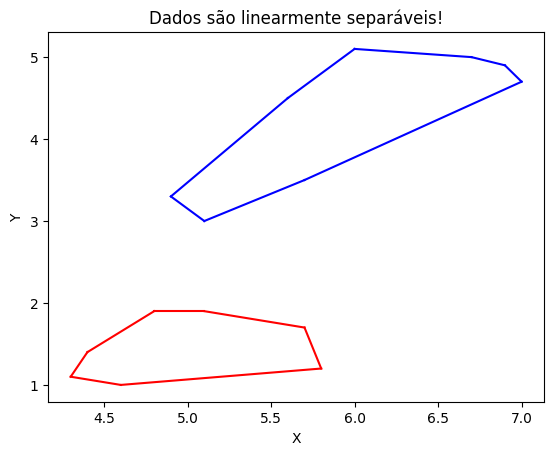

In [50]:
verificar_separabilidade_linear(versicolorEnv, setosaEnv)
plot_separabilidade(pointsVersicolor, pointsSetosa)

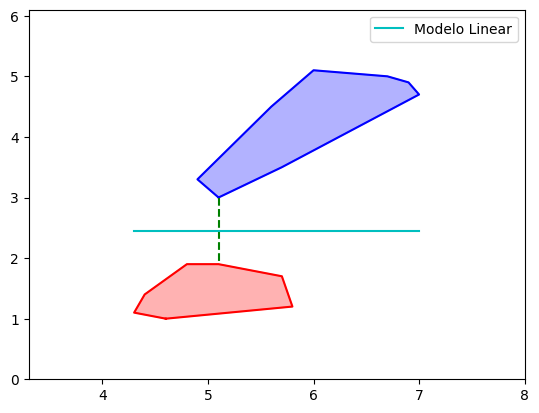

In [51]:
modelo = construir_modelo_linear(pointsVersicolor, pointsSetosa)
plot_modelo(pointsVersicolor, pointsSetosa)

In [52]:
precisao, revocacao, f1 = calcular_metricas_teste(pointsVersicolor, pointsSetosa, modelo)
print(f"Precisão: {precisao:.2f}")
print(f"Revocação: {revocacao:.2f}")
print(f"F1-score: {f1:.2f}")

Precisão: 1.00
Revocação: 1.00
F1-score: 1.00


In [53]:
def apply_pca(data, n_components=2):
    # Normaliza os dados
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data)
    
    # Aplica PCA
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(normalized_data)
    
    return pd.DataFrame(reduced_data, columns=[f'Componente {i+1}' for i in range(n_components)])

In [54]:
def prever(modelo, ponto, positive_label, negative_label):
    m, c = modelo[:2]
    if ponto.y > m * ponto.x + c:
        return positive_label
    else:
        return negative_label

def calcular_metricas(label_name, test, modelo, positive_label, negative_label):
    verdadeiros = test[label_name].tolist()
    previstos = [prever(modelo, Ponto(row['Componente 1'], row['Componente 2']), positive_label, negative_label) for _, row in test.iterrows()]
    
    tp = sum(1 for v, p in zip(verdadeiros, previstos) if v == positive_label and p == positive_label)
    fp = sum(1 for v, p in zip(verdadeiros, previstos) if v == negative_label and p == positive_label)
    fn = sum(1 for v, p in zip(verdadeiros, previstos) if v == positive_label and p == negative_label)
    
    precisao = tp / (tp + fp) if tp + fp != 0 else 0
    revocacao = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * (precisao * revocacao) / (precisao + revocacao) if (precisao + revocacao) != 0 else 0
    
    return precisao, revocacao, f1


#Testando com t-sne e aninhado

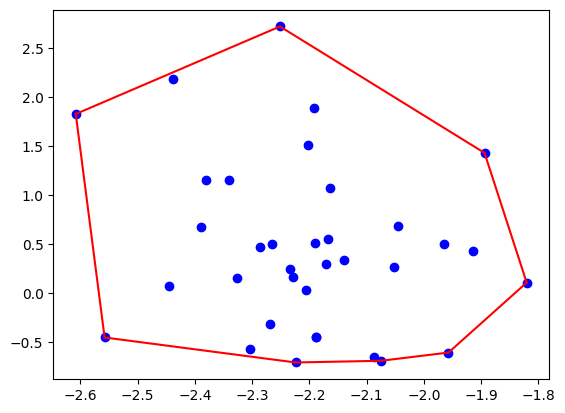

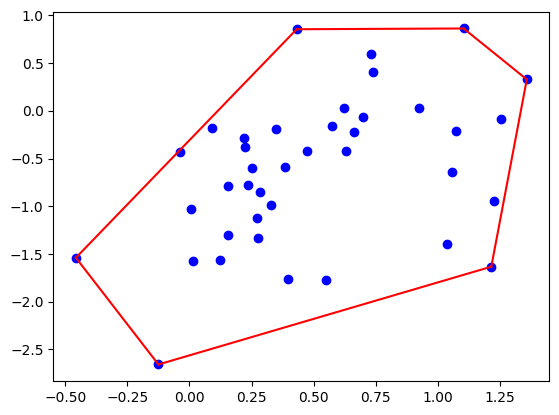

[(-2.2240827220450017, -0.709118158030226), (-2.075357592837306, -0.6919173471364096), (-1.9570240073413965, -0.6078925674838078), (-1.8204115633372133, 0.10675079283540627), (-1.8940742930236676, 1.431110706941237), (-2.2514652145840643, 2.722371076574469), (-2.6082028676633464, 1.8284751927341), (-2.557834419537513, -0.45381638048979317), (-2.2240827220450017, -0.709118158030226)]
[(-0.12469746138037062, -2.6580626779617607), (1.215303209216154, -1.633355644515482), (1.3582398473872712, 0.3288202662704021), (1.1039936528045722, 0.8631124458513245), (0.43178316074105333, 0.8551369202180025), (-0.4570128725046748, -1.5394645102639806), (-0.12469746138037062, -2.6580626779617607)]


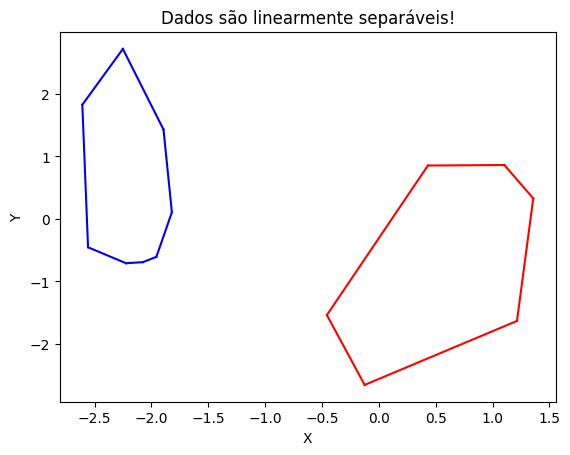

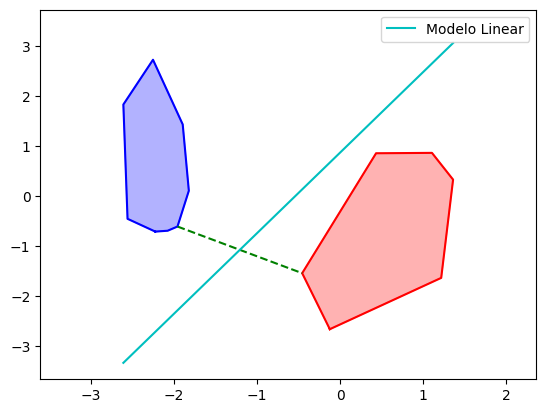

Precisão: 1.00
Revocação : 0.93
F1-score: 0.97


In [57]:
# Aplicando PCA
irisPCA = apply_pca(irisData.drop(labels=['class'], axis=1))
irisPCA['class'] = irisData['class']

irisTest = irisPCA.sample(frac = 0.3)
irisTrain = irisPCA.drop(irisTest.index)

# Acessando as classes separadamente com base na coluna 'class'
irisTrain0 = irisTrain[irisTrain['class'] == 'Iris-setosa']
irisTrain1 = irisTrain[irisTrain['class'] == 'Iris-versicolor']

# Convertendo para pontos
irisTrain0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in irisTrain0.iterrows()]
irisTrain1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in irisTrain1.iterrows()]

# Plotando o casco convexo
irisTrain0Env = graham_scan(irisTrain0Pts)
plot_envoltoria(irisTrain0Pts, irisTrain0Env)

irisTrain1Env = graham_scan(irisTrain1Pts)
plot_envoltoria(irisTrain1Pts, irisTrain1Env)

separavel = verificar_separabilidade_linear(irisTrain0Env, irisTrain1Env)
plot_separabilidade(irisTrain0Pts, irisTrain1Pts)

modelo = construir_modelo_linear(irisTrain0Pts, irisTrain1Pts)
if (modelo):
    plot_modelo(irisTrain0Pts, irisTrain1Pts)
    label_iris = 'class'
    precisao, revocacao, f1 = calcular_metricas(label_iris, irisTest, modelo, positive_label='Iris-setosa', negative_label='Iris-versicolor')
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação : {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")

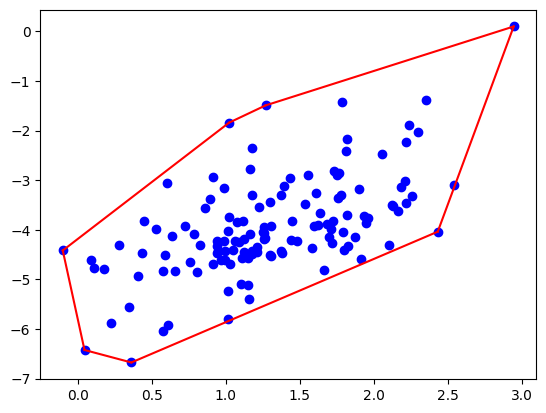

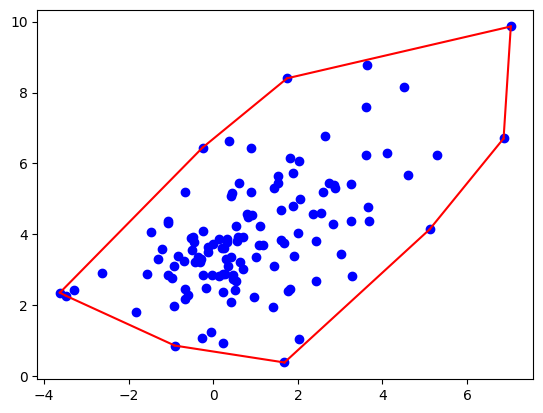

[(0.36269751607288975, -6.67531009379404), (2.429941248874979, -4.03713659231223), (2.942203208793897, 0.10078260099411321), (1.2676918110148139, -1.4916186567419965), (1.0220683036009177, -1.8388788260370805), (-0.10022383631590649, -4.416537437180341), (0.04644600386548072, -6.423441474758651), (0.36269751607288975, -6.67531009379404)]
[(1.6817158211867669, 0.3912630392730428), (5.11493052281335, 4.143981079858648), (6.862755558480268, 6.704675404766209), (7.0335938671358464, 9.861008366669012), (1.7437281124541277, 8.399923240762151), (-0.2522296018907567, 6.449437951029171), (-3.6272269365784036, 2.3588230163708412), (-3.483857711387637, 2.270918647219758), (-0.9113099614009864, 0.8676068798942396), (1.6817158211867669, 0.3912630392730428)]


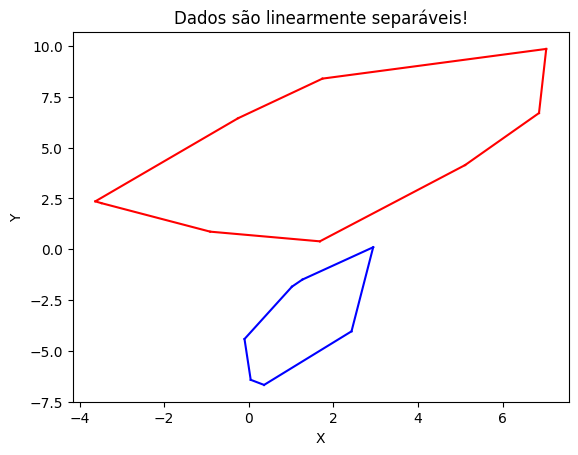

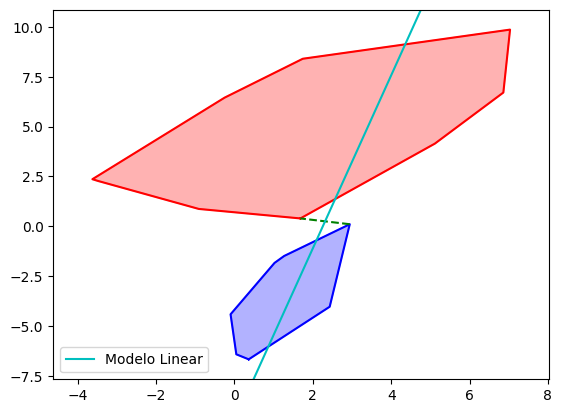

Precisão: 0.39
Revocação: 0.57
F1-score: 0.47


In [58]:
from sklearn.datasets import load_digits
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

digits = load_digits()
data = pd.DataFrame(digits.data)
data['label'] = digits.target

# Aplicando PCA
digitsPCA = apply_pca(data.drop(labels=['label'], axis=1))
digitsPCA['label'] = data['label']

digitsTest = digitsPCA.sample(frac = 0.3)
digitsTrain = digitsPCA.drop(digitsTest.index)

# Acessando as classes separadamente com base na coluna 'label'
digitsTrain4 = digitsTrain[digitsTrain['label'] == 6]
digitsTrain3 = digitsTrain[digitsTrain['label'] == 7]

# Convertendo para pontos
digitsTrain4Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in digitsTrain4.iterrows()]
digitsTrain3Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in digitsTrain3.iterrows()]

# Plotando o casco convexo
digitsTrain4Env = graham_scan(digitsTrain4Pts)
plot_envoltoria(digitsTrain4Pts, digitsTrain4Env)

digitsTrain3Env = graham_scan(digitsTrain3Pts)
plot_envoltoria(digitsTrain3Pts, digitsTrain3Env)

separavel = verificar_separabilidade_linear(digitsTrain4Env, digitsTrain3Env)
plot_separabilidade(digitsTrain4Pts, digitsTrain3Pts)

modelo = construir_modelo_linear(digitsTrain4Pts, digitsTrain3Pts)
if (modelo):
    plot_modelo(digitsTrain4Pts, digitsTrain3Pts)
    label_digits = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_digits, digitsTrain, modelo, positive_label=6, negative_label=7)  # Note que corrigi os labels
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")


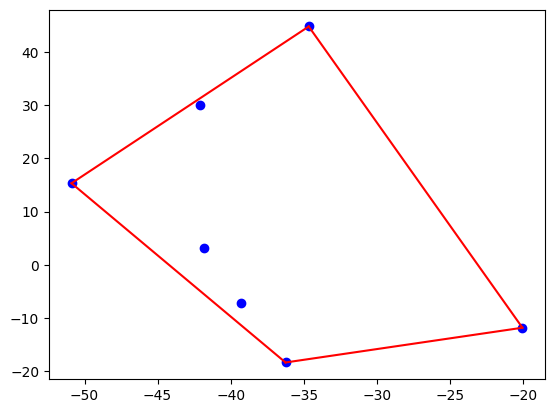

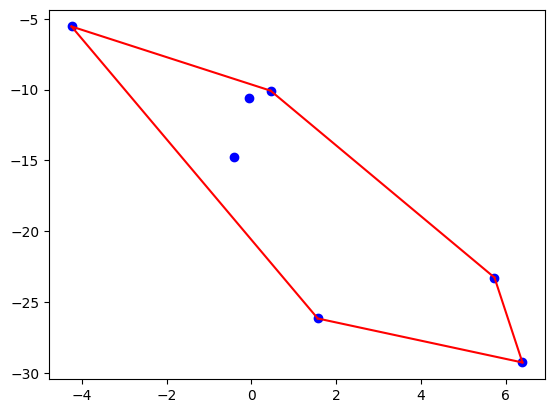

[(-36.2393913269043, -18.376827239990234), (-20.025501251220703, -11.839366912841797), (-34.65378189086914, 44.826908111572266), (-50.89067459106445, 15.336960792541504), (-36.2393913269043, -18.376827239990234)]
[(6.399694919586182, -29.25957489013672), (5.739424228668213, -23.266157150268555), (0.45025432109832764, -10.075637817382812), (-4.251429080963135, -5.545418739318848), (1.5654957294464111, -26.154666900634766), (6.399694919586182, -29.25957489013672)]


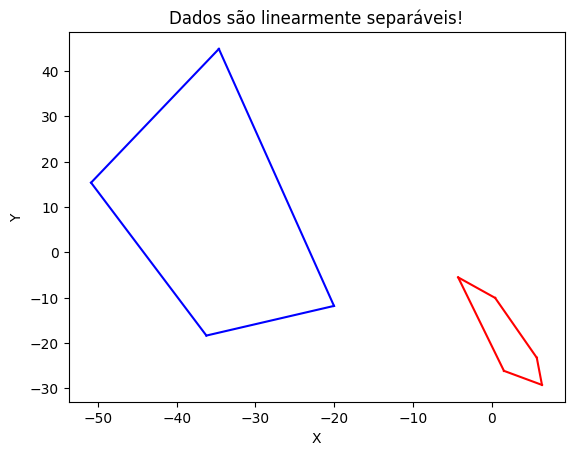

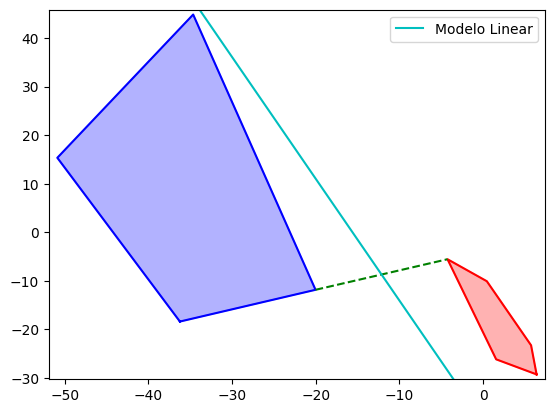

Precisão: 0.25
Revocação: 0.33
F1-score: 0.29


In [60]:
from sklearn.datasets import fetch_olivetti_faces

faces = fetch_olivetti_faces(shuffle=True)
data = pd.DataFrame(faces.data)
data['label'] = faces.target

# Aplicando PCA
facesPCA = apply_pca(data.drop(labels=['label'], axis=1))
facesPCA['label'] = data['label']

facesTest = facesPCA.sample(frac = 0.3)
facesTrain = facesPCA.drop(facesTest.index)

# Acessando as classes separadamente com base na coluna 'label'
facesTrain0 = facesTrain[facesTrain['label'] == 0]
facesTrain1 = facesTrain[facesTrain['label'] == 1]

# Convertendo para pontos
facesTrain0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in facesTrain0.iterrows()]
facesTrain1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in facesTrain1.iterrows()]

# Plotando o casco convexo
facesTrain0Env = graham_scan(facesTrain0Pts)
plot_envoltoria(facesTrain0Pts, facesTrain0Env)

facesTrain1Env = graham_scan(facesTrain1Pts)
plot_envoltoria(facesTrain1Pts, facesTrain1Env)

separavel = verificar_separabilidade_linear(facesTrain0Env, facesTrain1Env)
plot_separabilidade(facesTrain0Pts, facesTrain1Pts)

if separavel:
    modelo = construir_modelo_linear(facesTrain0Pts, facesTrain1Pts)
    plot_modelo(facesTrain0Pts, facesTrain1Pts)

    label_faces = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_faces, facesTest, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')

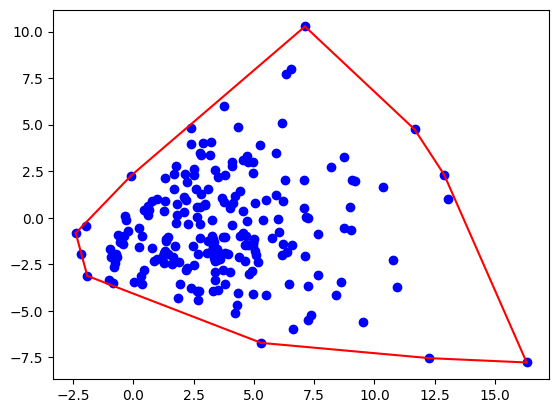

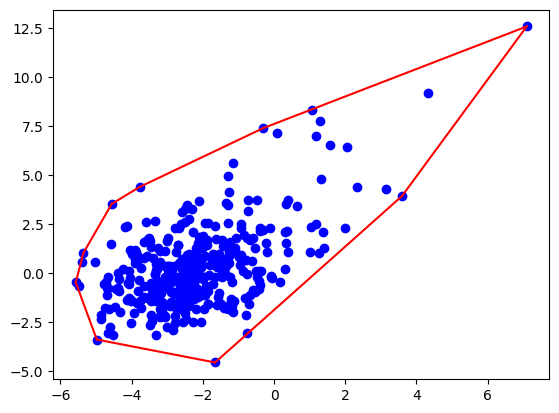

[(16.319233231031998, -7.775852804173332), (12.89461213396874, 2.3166224648625877), (11.668714648329491, 4.748617202597425), (7.122953197708968, 10.27558912163995), (-0.09333138656721593, 2.2607520062185174), (-2.3858827584205415, -0.8241155710179245), (-1.9087689281363955, -3.121945805441027), (5.307140022001264, -6.723414983609194), (12.285019759541237, -7.543410168979724), (16.319233231031998, -7.775852804173332)]
[(-1.654521845920802, -4.555664122438658), (3.591294118690399, 3.92633315543524), (7.093306714189175, 12.573194228898743), (-0.30785577047686213, 7.3878121770773655), (-3.765414553258793, 4.398200493465884), (-4.555028840448226, 3.5287860179972412), (-5.35161811493675, 1.0267578587528214), (-5.565735898981176, -0.47784757874152944), (-4.975702062159841, -3.386204867297522), (-1.654521845920802, -4.555664122438658)]


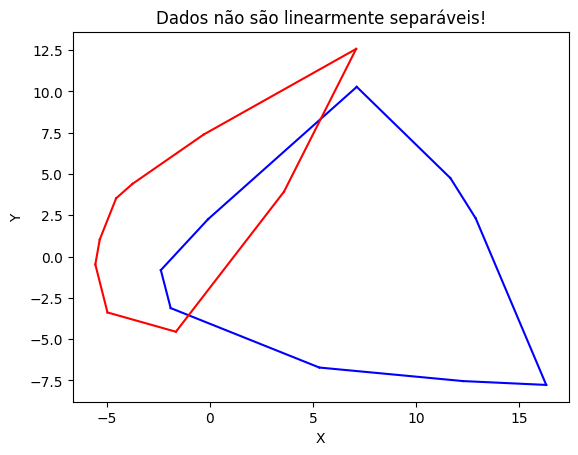

Os dados não são linearmente separáveis.


In [61]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

# Carregando os dados
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data)

# Adicionando uma coluna com os rótulos
data['label'] = cancer.target

cancerPCA = apply_pca(data.drop(labels=['label'], axis=1))
cancerPCA['label'] = data['label']  # Adicionando o rótulo de volta após o PCA

# Acessando as classes separadamente com base na coluna 'label'
cancerPCA0 = cancerPCA[cancerPCA['label'] == 0].reset_index(drop=True)
cancerPCA1 = cancerPCA[cancerPCA['label'] == 1].reset_index(drop=True)

# Convertendo para pontos
cancerPCA0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in cancerPCA0.iterrows()]
cancerPCA1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in cancerPCA1.iterrows()]

# Calculando e Plotando a envoltória convexa
cancerPCA0Env = graham_scan(cancerPCA0Pts)
plot_envoltoria(cancerPCA0Pts, cancerPCA0Env)

cancerPCA1Env = graham_scan(cancerPCA1Pts)
plot_envoltoria(cancerPCA1Pts, cancerPCA1Env)

separavel = verificar_separabilidade_linear(cancerPCA0Env, cancerPCA1Env)
plot_separabilidade(cancerPCA0Pts, cancerPCA1Pts)

if separavel:
    modelo = construir_modelo_linear(cancerPCA0Pts, cancerPCA1Pts)
    plot_modelo(cancerPCA0Pts, cancerPCA1Pts)

    label_cancer = 'label'
    precisao, revocacao, f1 = calcular_metricas(label_cancer, cancerPCA, modelo, positive_label=0, negative_label=1)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')


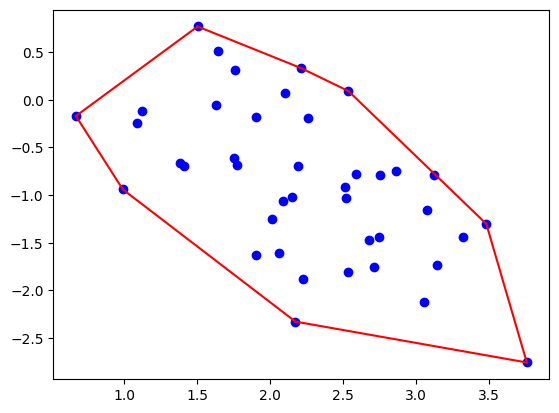

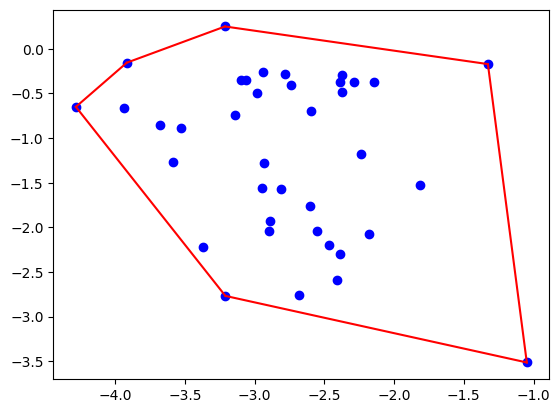

[(3.757065609773203, -2.756371913710712), (3.479736682731209, -1.3023332371235954), (2.5352240799037142, 0.0918406207208796), (2.2094649169188476, 0.3333928870802975), (1.5021945006181907, 0.7694320064310071), (0.6684819937541867, -0.16996094061987638), (0.9900791016088567, -0.9406673381906316), (2.171955273741513, -2.327305336191418), (3.757065609773203, -2.756371913710712)]
[(-1.048181896853676, -3.515089691219728), (-1.3271016561416025, -0.17038923204902767), (-3.211617215041247, 0.25124910442559145), (-3.915753783711889, -0.15458251944173237), (-4.280638778751086, -0.6496709640237057), (-3.2087581641980205, -2.7689195660475727), (-1.048181896853676, -3.515089691219728)]


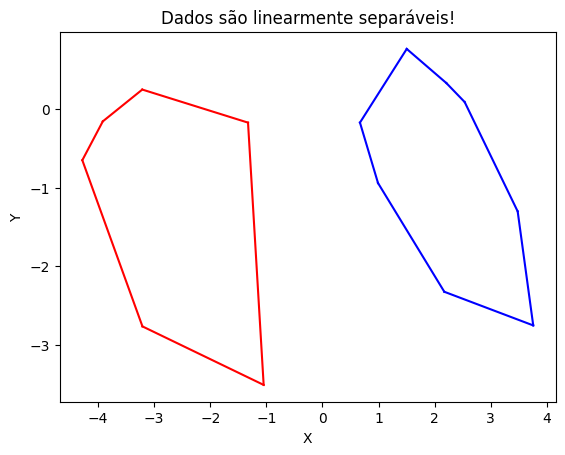

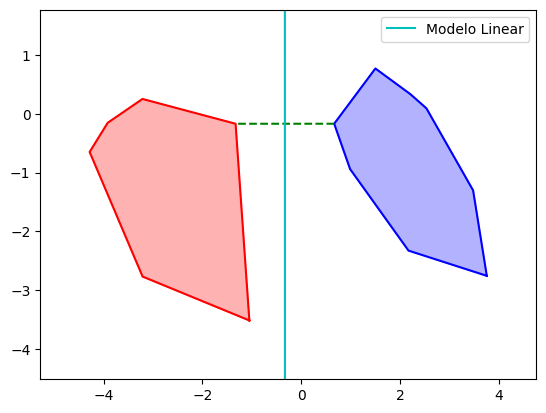

Precisão: 1.00
Revocação: 1.00
F1-score: 1.00


In [62]:
from sklearn.datasets import load_wine
import pandas as pd
from sklearn.decomposition import PCA

# Carregando os dados
wine = load_wine()
dataWine = pd.DataFrame(wine.data)

dataWine['label'] = wine.target

winePCA = apply_pca(dataWine.drop(labels=['label'], axis=1))

winePCA['label'] = dataWine['label']


# Dividindo os dados em conjuntos de treinamento e teste
wineTest = winePCA.sample(frac=0.3)
wineTrain = winePCA.drop(wineTest.index)

# Acessando as classes separadamente com base na coluna 'label'
winePCA0 = wineTrain[wineTrain['label'] == 0]
winePCA1 = wineTrain[wineTrain['label'] == 2]

# Convertendo para pontos
winePCA0Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in winePCA0.iterrows()]
winePCA1Pts = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in winePCA1.iterrows()]

# Calculando e Plotando a envoltória convexa
winePCA0Env = graham_scan(winePCA0Pts)
plot_envoltoria(winePCA0Pts, winePCA0Env)

winePCA1Env = graham_scan(winePCA1Pts)
plot_envoltoria(winePCA1Pts, winePCA1Env)

separavel = verificar_separabilidade_linear(winePCA0Env, winePCA1Env)
plot_separabilidade(winePCA0Pts, winePCA1Pts)

if separavel:
    modelo = construir_modelo_linear(winePCA0Pts, winePCA1Pts)
    plot_modelo(winePCA0Pts, winePCA1Pts)
    label_wine = 'label'

    precisao, revocacao, f1 = calcular_metricas(label_wine, wineTest, modelo, positive_label=0, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
else:
    print('Os dados não são linearmente separáveis.')


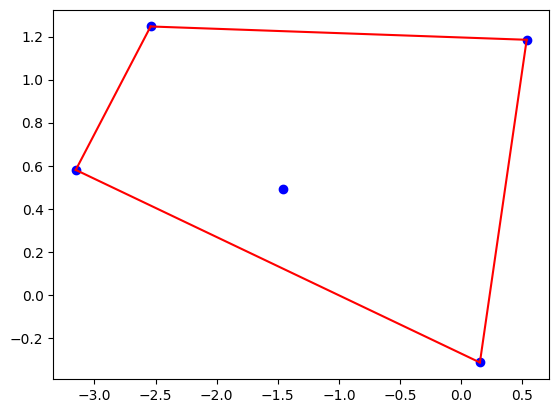

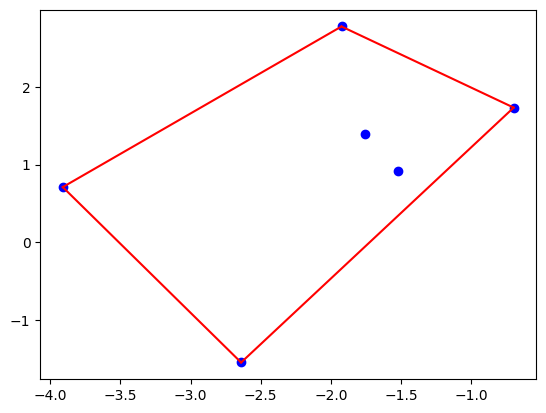

[(0.15319524045854277, -0.31436688022159714), (0.5359895637762222, 1.1851124901019572), (-2.540935851909289, 1.2469292240352243), (-3.1532392807723806, 0.5804699010834109), (0.15319524045854277, -0.31436688022159714)]
[(-2.6393873325185386, -1.5442858197906133), (-0.695879263240144, 1.7336679545001277), (-1.9235250630567051, 2.777092324217084), (-3.911177313536881, 0.7114499855363263), (-2.6393873325185386, -1.5442858197906133)]


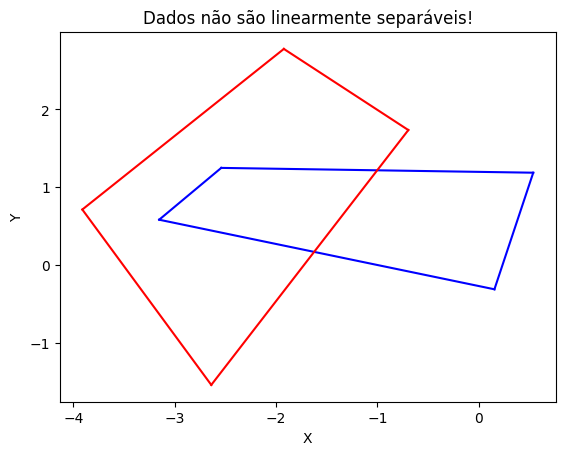

Os dados não são linearmente separáveis.


In [63]:
from sklearn.datasets import load_diabetes
import pandas as pd
from sklearn.decomposition import PCA


diabetes = load_diabetes()
data = pd.DataFrame(diabetes.data)

# Adicione uma coluna com os rótulos
data['label'] = diabetes.target

# Applying PCA for dimensionality reduction
diabetesPCA = apply_pca(data.drop(labels=['label'], axis=1))

diabetesPCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
diabetesTest = diabetesPCA.sample(frac=0.3)
diabetesTrain = diabetesPCA.drop(diabetesTest.index)

# Accessing the classes separately based on the 'label' column
diabetesPCA0 = diabetesPCA[data['label'] == 90.0].reset_index(drop=True)
diabetesPCA1 = diabetesPCA[data['label'] == 72.0].reset_index(drop=True)

# Convertendo em pontos
diabetesPCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in diabetesPCA0.iterrows()]
diabetesPCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for _, row in diabetesPCA1.iterrows()]

# Plotando a envoltória convexa
diabetesPCA0Env = graham_scan(diabetesPCA0)
plot_envoltoria(diabetesPCA0, diabetesPCA0Env)

diabetesPCA1Env = graham_scan(diabetesPCA1)
plot_envoltoria(diabetesPCA1, diabetesPCA1Env)

verificar_separabilidade_linear(diabetesPCA0Env, diabetesPCA1Env)
plot_separabilidade(diabetesPCA0, diabetesPCA1)

modelo = construir_modelo_linear(diabetesPCA0, diabetesPCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas(diabetesTrain, diabetesTest, modelo, 90, 72)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")


     4     5  6  7  8  9 10 11 12 13  ...  32   33   34    35   36   37   38  \
0  181  5450  0  0  0  0  0  1  0  0  ...   9  1.0  0.0  0.11  0.0  0.0  0.0   
1  239   486  0  0  0  0  0  1  0  0  ...  19  1.0  0.0  0.05  0.0  0.0  0.0   
2  235  1337  0  0  0  0  0  1  0  0  ...  29  1.0  0.0  0.03  0.0  0.0  0.0   
3  219  1337  0  0  0  0  0  1  0  0  ...  39  1.0  0.0  0.03  0.0  0.0  0.0   
4  217  2032  0  0  0  0  0  1  0  0  ...  49  1.0  0.0  0.02  0.0  0.0  0.0   

    39   40 label  
0  0.0  0.0    11  
1  0.0  0.0    11  
2  0.0  0.0    11  
3  0.0  0.0    11  
4  0.0  0.0    11  

[5 rows x 38 columns]


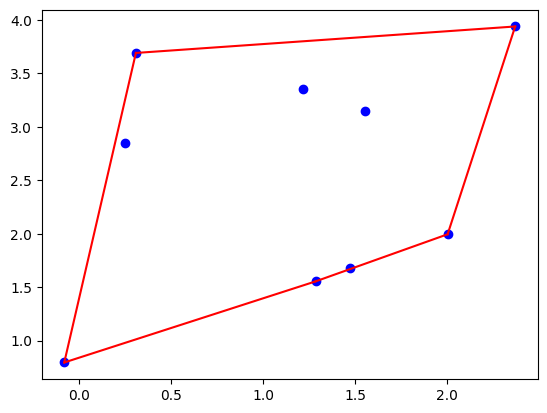

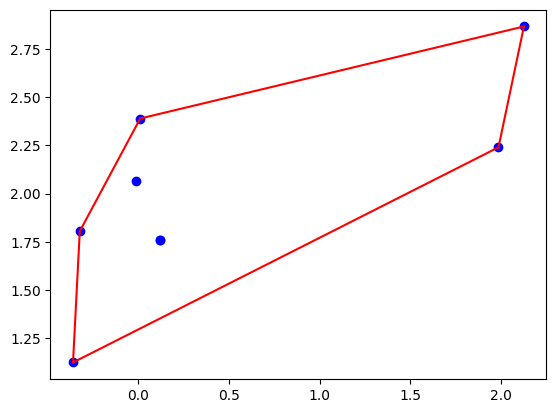

[(-0.08136414983359903, 0.7951422514226139), (1.2837001822873095, 1.5537810337269238), (2.001458580660876, 1.9950075609803126), (2.3685102605548822, 3.939561591913139), (0.307806479546691, 3.691828016827949), (-0.08136414983359903, 0.7951422514226139)]
[(-0.3609493942276786, 1.1251753707234884), (1.9869796443117833, 2.239736448849414), (2.127312885105082, 2.8654440264063945), (0.009917008271865922, 2.388744884156056), (-0.32366080895814076, 1.8047733899785239), (-0.3609493942276786, 1.1251753707234884)]


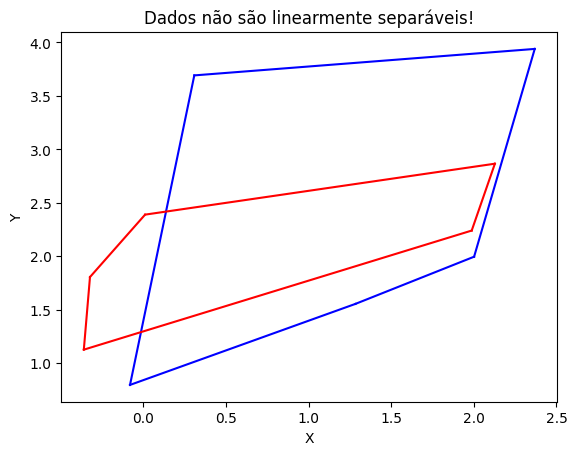

Os dados não são linearmente separáveis.


In [64]:
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import pandas as pd

kddcup99 = fetch_kddcup99()
data = pd.DataFrame(kddcup99.data)

# Adicione uma coluna com os rótulos
data['label'] = kddcup99.target

# Crie uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Ajuste e transforme os rótulos
data['label'] = label_encoder.fit_transform(data['label'])

# Remova as colunas não númericas
colunas_a_remover = [0, 1, 2, 3]  # Índices das colunas a serem removidas
data = data.drop(data.columns[colunas_a_remover], axis=1)

print(data.head())

# Use PCA for dimensionality reduction
kddcup99PCA = apply_pca(data.drop(labels=['label'], axis=1))

kddcup99PCA['label'] = data['label']

# Dividindo os dados em conjuntos de treinamento e teste
kddcup99Test = kddcup99PCA.sample(frac=0.3)
kddcup99Train = kddcup99PCA.drop(kddcup99Test.index)

# Acesse as classes separadamente com base na coluna 'label'
kddcup99PCA0 = kddcup99PCA[data['label'] == 7].reset_index(drop=True)
kddcup99PCA1 = kddcup99PCA[data['label'] == 2].reset_index(drop=True)

# Convertendo em pontos
kddcup99PCA0 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in kddcup99PCA0.iterrows()]
kddcup99PCA1 = [Ponto(row['Componente 1'], row['Componente 2']) for index, row in kddcup99PCA1.iterrows()]

# Plotando a envoltória convexa
kddcup99PCA0Env = graham_scan(kddcup99PCA0)
plot_envoltoria(kddcup99PCA0, kddcup99PCA0Env)

kddcup99PCA1Env = graham_scan(kddcup99PCA1)
plot_envoltoria(kddcup99PCA1, kddcup99PCA1Env)

verificar_separabilidade_linear(kddcup99PCA0Env, kddcup99PCA1Env)
plot_separabilidade(kddcup99PCA0, kddcup99PCA1)

modelo = construir_modelo_linear(kddcup99PCA0, kddcup99PCA1)

if modelo:
    precisao, revocacao, f1 = calcular_metricas('label', kddcup99Test, modelo, positive_label=7, negative_label=2)
    print(f"Precisão: {precisao:.2f}")
    print(f"Revocação: {revocacao:.2f}")
    print(f"F1-score: {f1:.2f}")
